# HOMEWORK 2
## Pixel-wise colour balancing based on von Kries’ hypothesis

In [275]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
plt.rcParams['figure.figsize'] = [15, 5]

## White patch
In white patch algorithm we choose a group of pixels we know they should be white. We then scale the resulting image colour channels by this white patch.

Shape: (350, 625, 3)


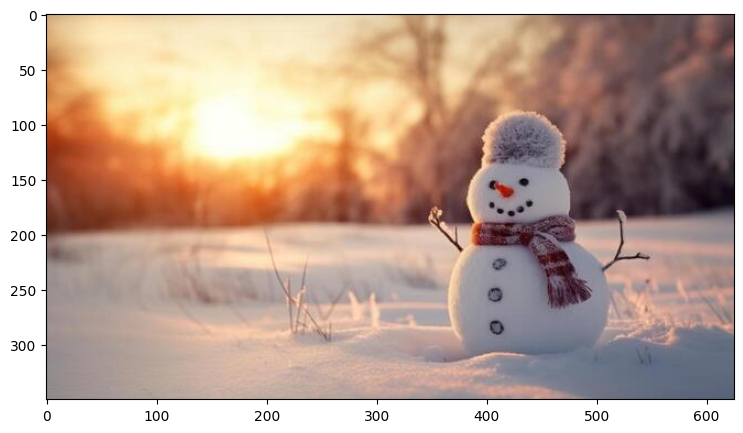

In [276]:
img1 = cv2.imread('data/snownam.jpg')
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print(f'Shape: {img1_rgb.shape}')
plt.imshow(img1_rgb)

In [277]:
def show_comparison(img_original, img_balanced, titles=("Original", "Balanced")):
    """
    Display the original and processed images side by side for comparison.
    """
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.title(titles[0])
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_balanced)
    plt.title(titles[1])
    plt.axis("off")

    plt.show()

### White Patch (Manual White Reference)

This method performs colour balancing by explicitly selecting a pixel that is assumed to represent a white surface in the scene. The colour channels are independently scaled so that the selected reference pixel is mapped to white.

The approach can provide strong correction when a reliable white reference is available, but it is highly sensitive to noise, saturation and inaccuracies in the manual selection of the white pixel.

In [278]:
def white_patch(img, row, col):
    """
    White Patch color balancing.
    A single pixel (row, col) is assumed to be white.
    """

    img = img.astype(np.float32)

    white = img[row, col, :]
    white = np.maximum(white, 1e-6)

    coeffs = 255.0 / white
    print(coeffs)

    balanced = img * coeffs

    balanced /= 255.0
    balanced = np.clip(balanced, 0, 1)

    return balanced

[1.2142857 1.4166666 1.5088757]


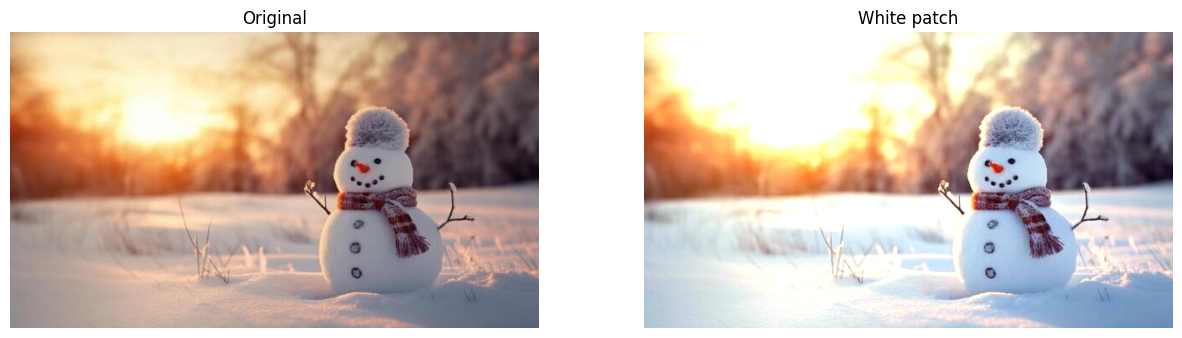

In [279]:
white_patch_img1 = white_patch(img1_rgb, 320,150)

show_comparison(img1_rgb, white_patch_img1, titles=("Original", "White patch"))

### Automatic White Patch (Document-Oriented)

This method is primarily intended for document-like images, where the background is assumed to be white and occupies a large portion of the image.
The white reference is estimated from the brightest pixels, making the approach robust for scanned documents and musical scores.

Shape: (1280, 972, 3)


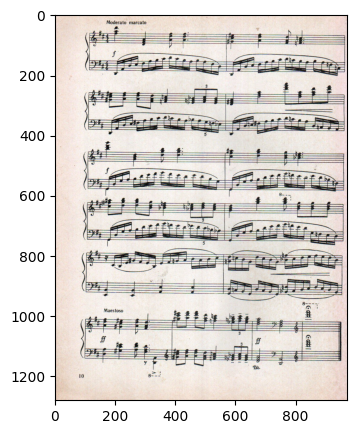

In [280]:
img2 = cv2.imread('data/sheet_music.jpg')
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
print(f'Shape: {img2_rgb.shape}')
plt.imshow(img2_rgb)

In [282]:
def white_balance_notes(
    image_path,
    output_image_path=None,
    output_pdf_path=None,
    brightest_percent=99
):
    """
    White balance for musical notes using an automatic White Patch approach.
    The white reference is estimated from the brightest pixels.
    """

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Unable to load image.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    brightness = img.mean(axis=2)

    threshold = np.percentile(brightness, 100 - brightest_percent)
    white_pixels = img[brightness >= threshold]

    if white_pixels.size == 0:
        raise ValueError("No white pixels detected")

    ref_pixel = white_pixels.mean(axis=0)
    ref_pixel = np.maximum(ref_pixel, 1e-6)

    scale = 255.0 / ref_pixel
    scale = np.clip(scale, 0, 10)

    img *= scale
    img = np.clip(img, 0, 255).astype(np.uint8)

    if output_image_path:
        cv2.imwrite(output_image_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    pil_img = Image.fromarray(img)

    if output_pdf_path:
        pil_img.save(output_pdf_path, "PDF", resolution=100.0)

    return pil_img


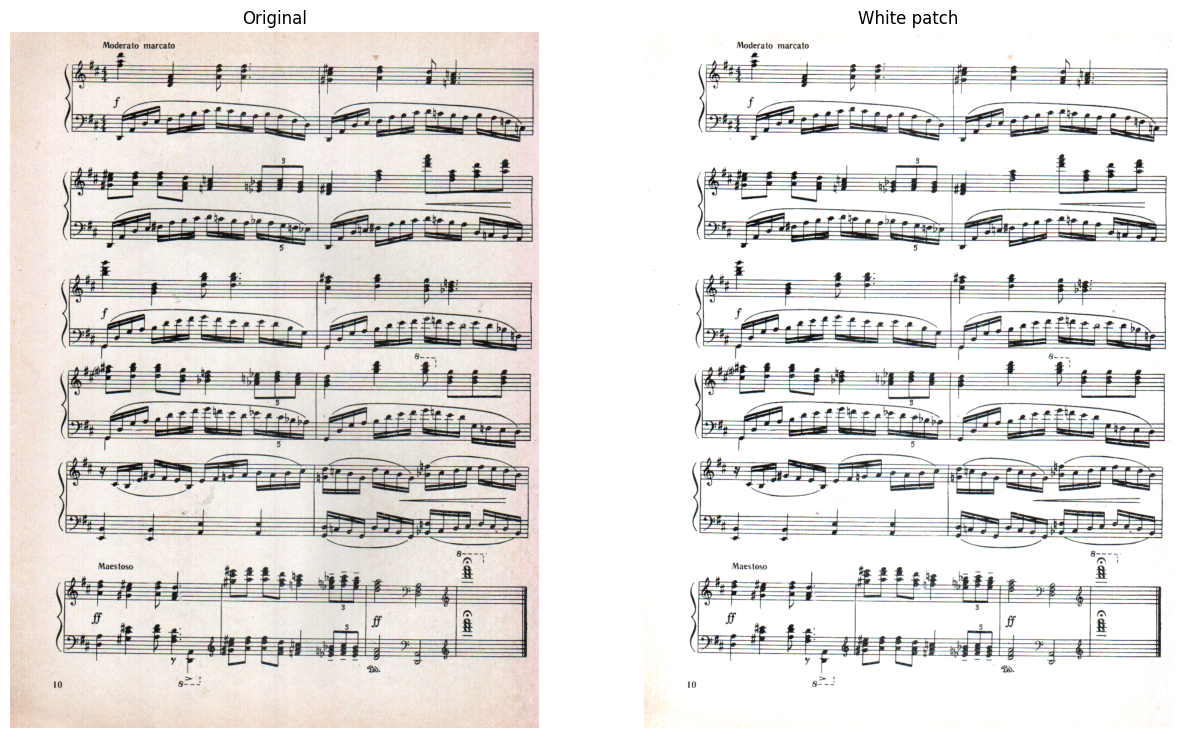

In [283]:
white_patch_img2 = white_balance_notes('data/sheet_music.jpg')
show_comparison(img2_rgb, white_patch_img2, titles=("Original", "White patch"))

## Gray world
This algorithm assumes that a scene, on average, is gray.

Shape: (552, 736, 3)


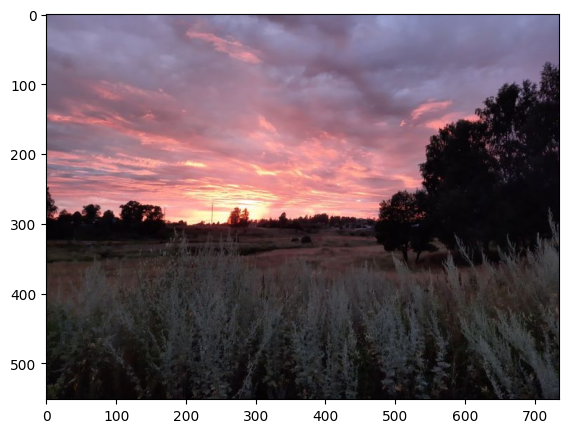

In [284]:
img3 = cv2.imread('data/evening_landscape.jpg')
img3_rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
print(f'Shape: {img3_rgb.shape}')
plt.imshow(img3_rgb)

In [285]:
def plot_rgb_hist_comparison(img_before, img_after, titles=("Original", "Balanced")):
    """
    Plot RGB histograms of two images side by side for comparison.
    """
    colors = ['r', 'g', 'b']
    labels = ['Red', 'Green', 'Blue']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    for ax, img, title in zip(axes, [img_before, img_after], titles):
        for i in range(3):
            ax.hist(
                img[..., i].ravel(),
                bins=256,
                range=(0, 256),
                color=colors[i],
                alpha=0.5,
                label=labels[i]
            )
        ax.set_title(title)
        ax.set_xlabel("Pixel value")
        ax.set_ylabel("Count")
        ax.legend()

    plt.tight_layout()
    plt.show()

### Gray World with Brightest Channel Normalization

In [288]:
def gray_world_brightest_norm(img):
    """
    Gray World color balancing with brightest channel normalization.
    The brightest channel is used as a reference (its scale is fixed to 1).
    """

    img = img.astype(np.float32)

    mean_r = img[..., 0].mean()
    mean_g = img[..., 1].mean()
    mean_b = img[..., 2].mean()

    means = np.array([mean_r, mean_g, mean_b])
    brightest = np.argmax(means)

    kr, kg, kb = 1.0, 1.0, 1.0

    if brightest == 0: 
        kg = mean_r / mean_g
        kb = mean_r / mean_b
    elif brightest == 1: 
        kr = mean_g / mean_r
        kb = mean_g / mean_b
    else: 
        kr = mean_b / mean_r
        kg = mean_b / mean_g

    coeffs = np.array([kr, kg, kb])

    balanced = img * coeffs
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)

    return balanced



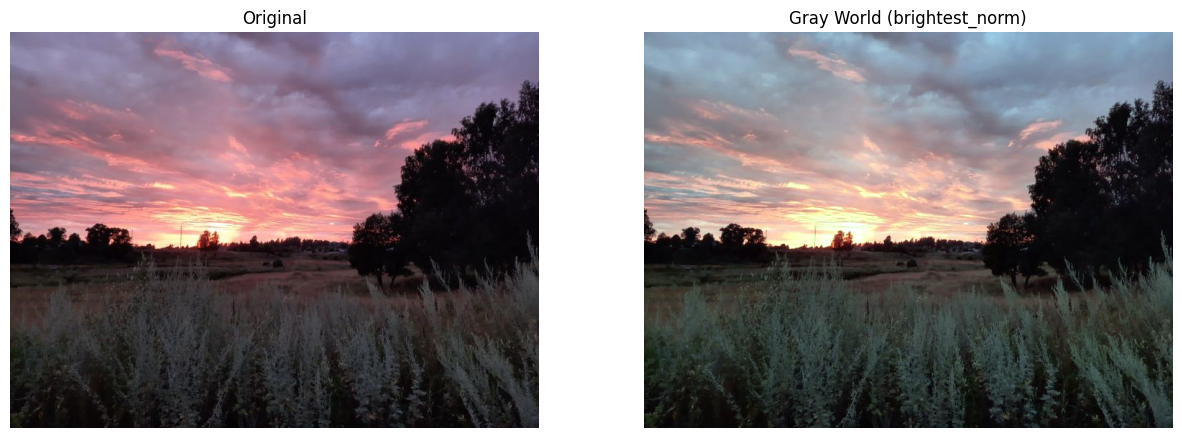

In [289]:
gray_worls_v1 = gray_world_brightest_norm(img3_rgb)
show_comparison(img3_rgb, gray_worls_v1, titles=("Original", "Gray World (brightest_norm)"))

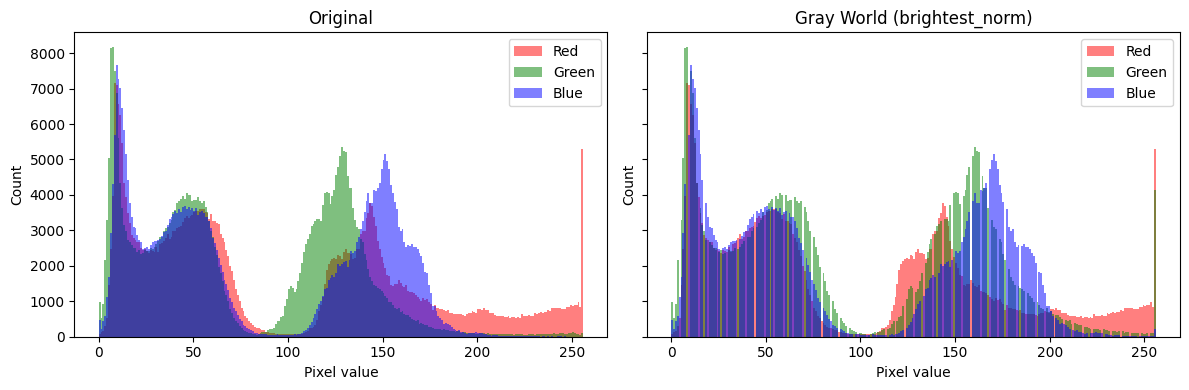

In [290]:
plot_rgb_hist_comparison(img3_rgb, gray_worls_v1,  titles=("Original",  "Gray World (brightest_norm)"))

### Gray World with Mean Equalization

In [291]:
def gray_world_mean_equalization(img):
    """
    Classic Gray World color balancing using channel mean equalization.
    """

    img = img.astype(np.float32)

    mean_r = img[..., 0].mean()
    mean_g = img[..., 1].mean()
    mean_b = img[..., 2].mean()

    gray_mean = (mean_r + mean_g + mean_b) / 3.0

    coeffs = np.array([
        gray_mean / mean_r,
        gray_mean / mean_g,
        gray_mean / mean_b
    ])

    balanced = img * coeffs
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)

    return balanced


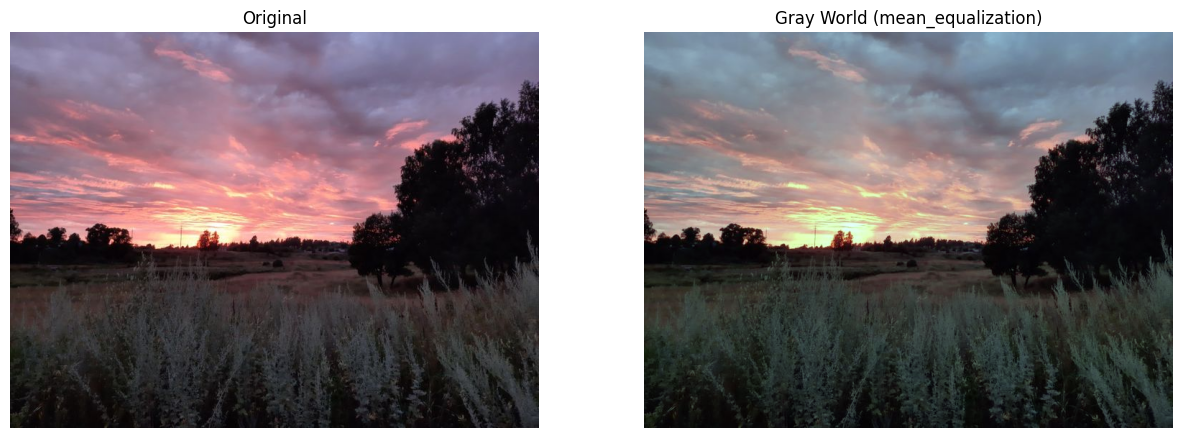

In [292]:
gray_worls_v2 = gray_world_mean_equalization(img3_rgb)
show_comparison(img3_rgb, gray_worls_v2, titles=("Original", "Gray World (mean_equalization)"))

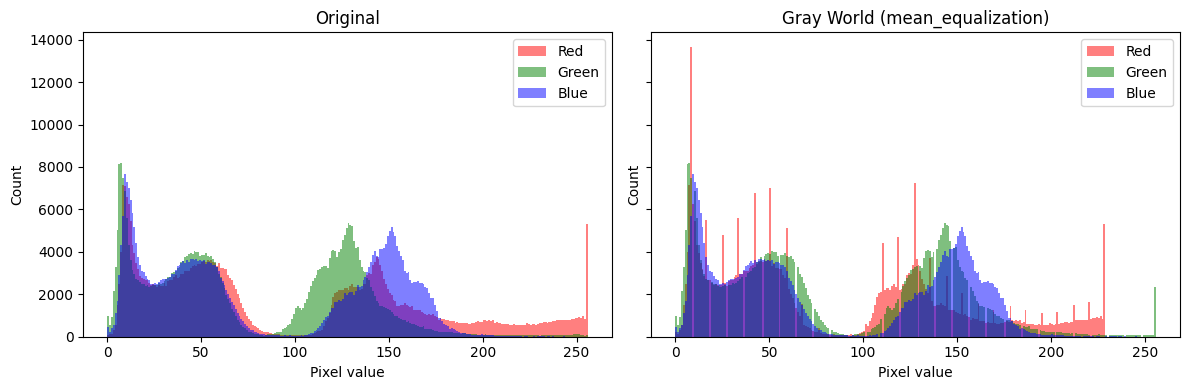

In [293]:
plot_rgb_hist_comparison(img3_rgb,  gray_worls_v2, titles=("Original", "Gray World (mean_equalization)"))

The classic Gray World algorithm enforces equal mean values across RGB channels.
While this assumption is mathematically satisfied, histogram analysis reveals significant saturation and quantization effects due to aggressive scaling, especially when channel means differ strongly.

The brightest-channel normalization variant provides a more conservative correction at the cost of introducing an additional heuristic assumption.

## Scale-by-max
This is a straightforward algorithm that scales each colour channel by its maximum value. It is sensitive to noise and saturations.

Shape: (840, 1600, 3)


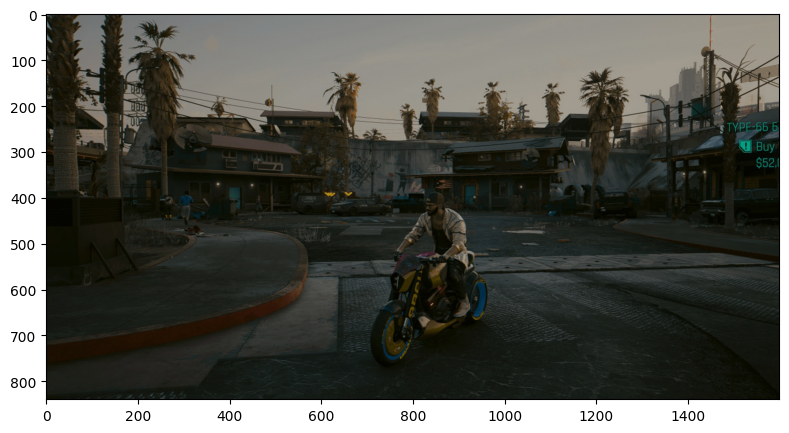

In [294]:
img4 = cv2.imread('data/biker.jpg')
img4_rgb = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
print(f'Shape: {img4_rgb.shape}')
plt.imshow(img4_rgb)

In [295]:
def scale_by_max(img):
    """
    Scale-by-max color balancing.
    Each color channel is scaled by its maximum intensity value.
    """

    img = img.astype(np.float32)

    max_vals = img.max(axis=(0, 1))
    max_vals = np.maximum(max_vals, 1e-6)

    balanced = img * (255.0 / max_vals)
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)

    return balanced


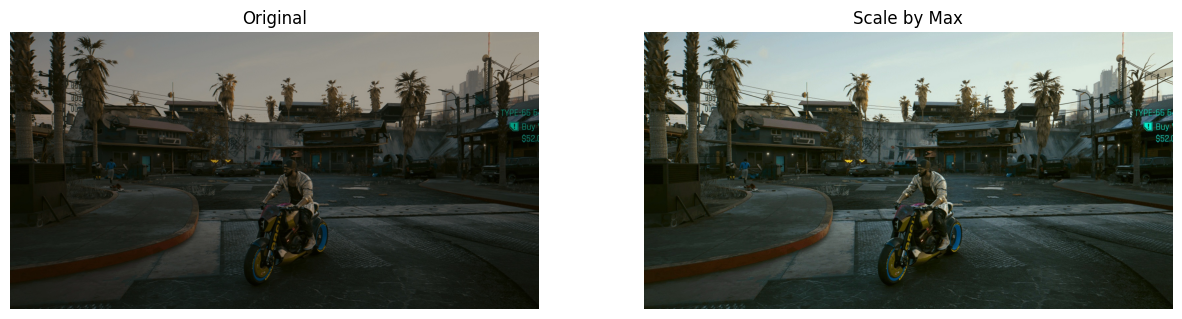

In [297]:
scale_by_max_img4 = scale_by_max(img4_rgb)
show_comparison(img4_rgb, scale_by_max_img4, titles=("Original", "Scale by Max"))

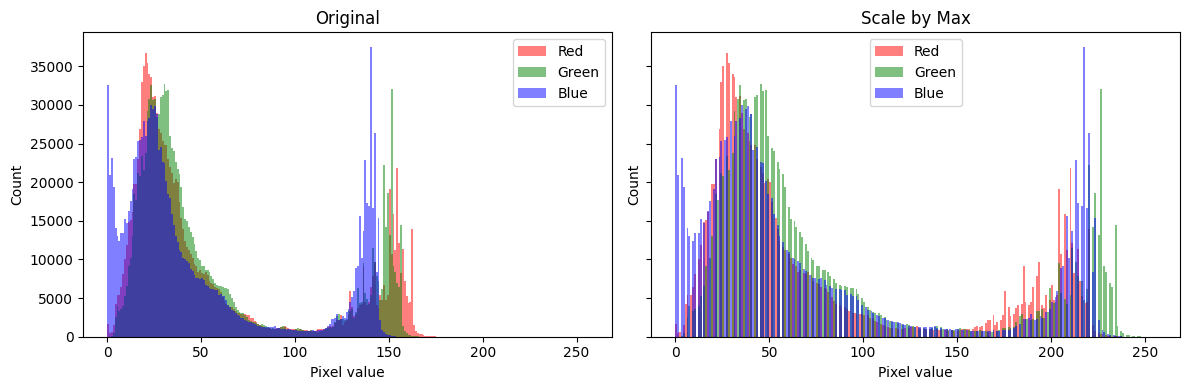

In [298]:
plot_rgb_hist_comparison(img4_rgb, scale_by_max_img4, titles=("Original", "Scale by Max"))

Scale-by-max normalizes each color channel using its maximum intensity value.
As a result, the method is highly sensitive to noise, outliers, and saturated pixels, since a single extreme value can dominate the scaling.
This often leads to loss of dynamic range and color distortions in real-world images.

To reduce the sensitivity of the scale-by-max method to noise and saturated pixels, a percentile-based variant was also implemented.
Instead of the maximum value, a high percentile of the intensity distribution is used for scaling, providing a more robust normalization while preserving the main idea of the algorithm.

In [299]:
def scale_by_percentile(img, percentile=99):
    """
    Scale-by-percentile color balancing.
    Each color channel is scaled using a high percentile
    to reduce sensitivity to noise and saturation.
    """

    img = img.astype(np.float32)

    # compute high percentile per channel
    scale_vals = np.percentile(img, percentile, axis=(0, 1))
    scale_vals = np.maximum(scale_vals, 1e-6)

    balanced = img * (255.0 / scale_vals)
    balanced = np.clip(balanced, 0, 255).astype(np.uint8)

    return balanced


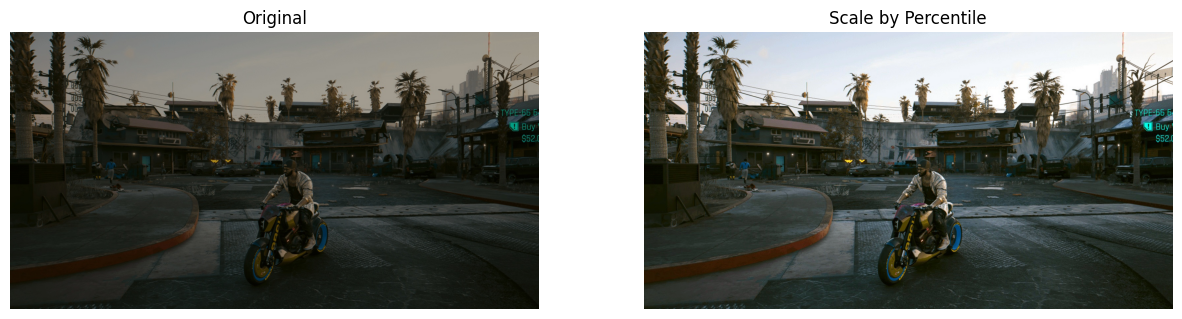

In [300]:
scale_by_percentile_img4 = scale_by_percentile(img4_rgb)
show_comparison(img4_rgb, scale_by_percentile_img4, titles=("Original", "Scale by Percentile"))

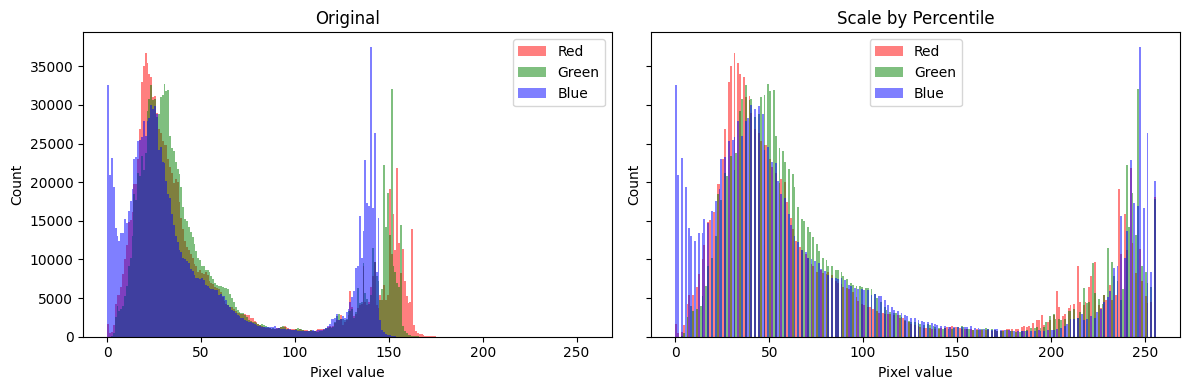

In [301]:
plot_rgb_hist_comparison(img4_rgb, scale_by_percentile_img4, titles=("Original", "Scale by Percentile"))

In this work, several colour balancing methods based on von Kries’ hypothesis were implemented and analysed, including White Patch, Gray World, and Scale-by-Max techniques.
Each method applies independent per-channel scaling in RGB space, but differs in how the scaling coefficients are estimated.

White Patch relies on the presence of a white reference and can provide strong correction, but is sensitive to noise and saturation.
Gray World assumes that the average scene colour is gray, offering a more stable and statistically grounded correction, though it may fail for scenes dominated by a single colour.
Scale-by-Max normalizes channel dynamic ranges and is effective only when a channel underutilizes its intensity range, making it highly sensitive to outliers and often ineffective for natural images.

The experiments demonstrate that no single method is universally optimal.
Each algorithm is suitable for specific image characteristics, highlighting the importance of understanding both the assumptions and limitations underlying von Kries-based colour balancing approaches.